# Importing Libraries

In [3]:
%pip install osmnx
%pip install geojson
%pip install geopandas folium
%pip install pulp
%pip install matplotlib
%pip install geoplot
%pip install seaborn
%pip install rasterio
%pip install rasterstats
%pip install contextily

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, PULP_CBC_CMD
import geopandas as gpd
import geoplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx
import rasterio
from rasterstats import zonal_stats
# import timeit
import time
from geojson import Point
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import random
from scipy.spatial import cKDTree

# Data

## Map (graph)

In [5]:
G_lviv = ox.graph_from_place('Lviv, Ukraine', network_type='drive')
# G_lviv = ox.graph_from_place('Frankivskyi District, Lviv, Ukraine', network_type='drive')
# G_lviv = ox.graph_from_place('Shevchenkivskyi District, Lviv, Ukraine', network_type='drive')
# G_lviv = ox.graph_from_place('Lychakivskyi District, Lviv, Ukraine', network_type='drive')

## Notations

$N$ - number of nodes in graph (map)\
$n_i$ - node id, $i \in [0, N-1]$\
$D_{i,j}$ - distance between $i$ node and $j$ node,   $i, j \in [0, N-1]$\
$R$ - number of regions\
$r_i$ - $i$ region, $i \in [0, R-1]$\
$q_i$ - capacity demand in $r_i$ region, $i \in [0, R-1]$\
$C_2$ - level 2 station cost\
$C_3$ - level 3 station cost\
$Q_2$ - level 2 station capacity\
$Q_3$ - level 3 station capacity\
$X_{2, i}$ - number of level 2 stations in node $i$, $i \in [0, N-1]$\
$X_{3, i}$ - number of level 3 stations in node $i$, $i \in [0, N-1]$

## Station and Region Data

Node id

In [6]:
nodes = list(G_lviv.nodes)    # n_i

nodes_dict = {    # n_i -> i
    nodes[i]: i
    for i in range(len(nodes))
}

Number of nodes

In [7]:
N = len(nodes)    # N

Station cost

In [8]:
level_2_cost = 125   # C_2
level_3_cost = 300   # C_3

Station capacity

In [202]:
level_2_capacity = 50 * 1000   # Q_2
level_3_capacity = 120 *1000  # Q_3

Number of regions

In [186]:
# R = 6    # R

Regions

In [11]:
# regions = dict()   # r_i

# regions[0] = nodes[:N//6]
# regions[1] = nodes[N//6 : 2*N//6]
# regions[2] = nodes[2*N//6 : 3*N//6]
# regions[3] = nodes[3*N//6 : 4*N//6]
# regions[4] = nodes[4*N//6 : 5*N//6]
# regions[5] = nodes[5*N//6:]

Regions capacity demand

In [12]:
# region_capacity_demand = dict()   # q_i

# region_capacity_demand[0] = 500
# region_capacity_demand[1] = 300
# region_capacity_demand[2] = 600
# region_capacity_demand[3] = 1000
# region_capacity_demand[4] = 400
# region_capacity_demand[5] = 1500

# Distance matrix (Floyd Warshall algorithm)

In [13]:
def distamnce_matrix(G):
    nodes = G.nodes
    n = len(nodes)
    print(n)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length

    for i in range(n): 
        D[i, i] = 0
    
    for k in range(n):
        print(k)
        for i in range(n):
            for j in range(n):
                D[i,j] = min (D[i, j], D[i, k] + D[k, j])
    return D


In [ ]:
# D = distamnce_matrix(G_lviv)

In [56]:
# D_Lviv = D
# submatrix = D_Lviv[:5,:5]
# print(submatrix)

[[   0.     869.897 1348.736 1513.452 2983.037]
 [ 869.897    0.     489.51   654.226 2123.811]
 [1719.989 1074.307    0.     164.716 1634.301]
 [1835.673 1022.246  676.399    0.    1469.585]
 [3062.258 2192.361 2308.396 1988.717    0.   ]]


## Saving distance matrix

In [53]:
# np.save("distance_matrix_lviv.npy", D_Lviv)

## Loading distance matrix

In [14]:
loaded_dist_matrix = np.load("distance_matrix_lviv.npy")
submatrix = loaded_dist_matrix[:5,:5]
print(submatrix)

[[   0.     869.897 1348.736 1513.452 2983.037]
 [ 869.897    0.     489.51   654.226 2123.811]
 [1719.989 1074.307    0.     164.716 1634.301]
 [1835.673 1022.246  676.399    0.    1469.585]
 [3062.258 2192.361 2308.396 1988.717    0.   ]]


In [15]:
D_Lviv = loaded_dist_matrix

## Check for one-directional edges

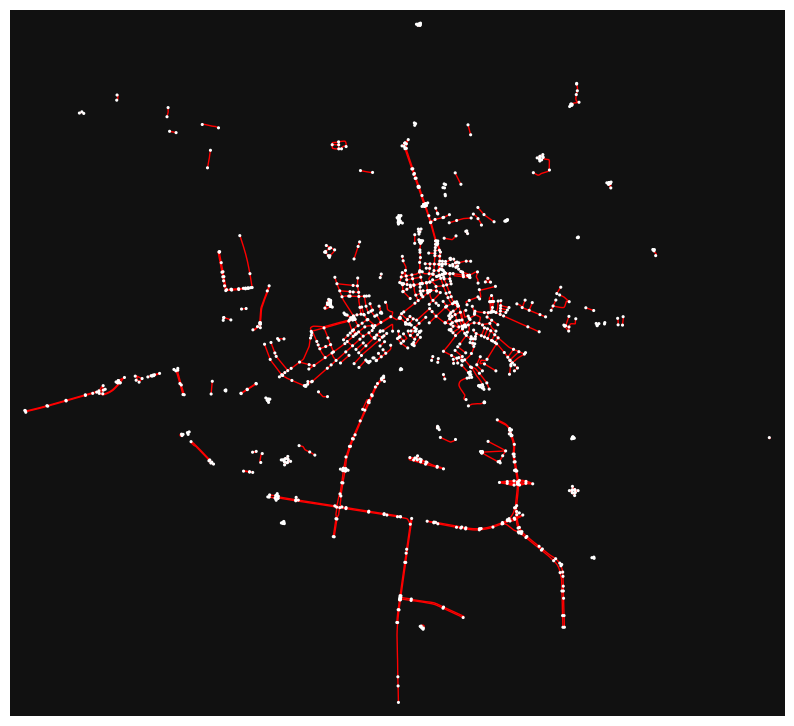

The graph contains 1360 one-direction roads.


In [39]:
# Step 1: Create the graph
place_name = "Lviv, Ukraine"
graph = ox.graph_from_place(place_name, network_type="drive")

# Step 2: Identify one-direction roads
one_direction_edges = [
    (u, v, k) for u, v, k, data in graph.edges(keys=True, data=True) if data.get("oneway", False)
]

# Step 3: Create a subgraph for one-direction roads
one_direction_graph = graph.edge_subgraph(one_direction_edges).copy()

# Step 4: Plot the one-direction roads
fig, ax = ox.plot_graph(one_direction_graph, node_size=5, edge_color="red", edge_linewidth=1, figsize=(10,10))

# Optionally, check if there are any one-direction roads
if one_direction_edges:
    print(f"The graph contains {len(one_direction_edges)} one-direction roads.")
else:
    print("The graph does not contain any one-direction roads.")


# Capacity demand prediction

## Division into sectors

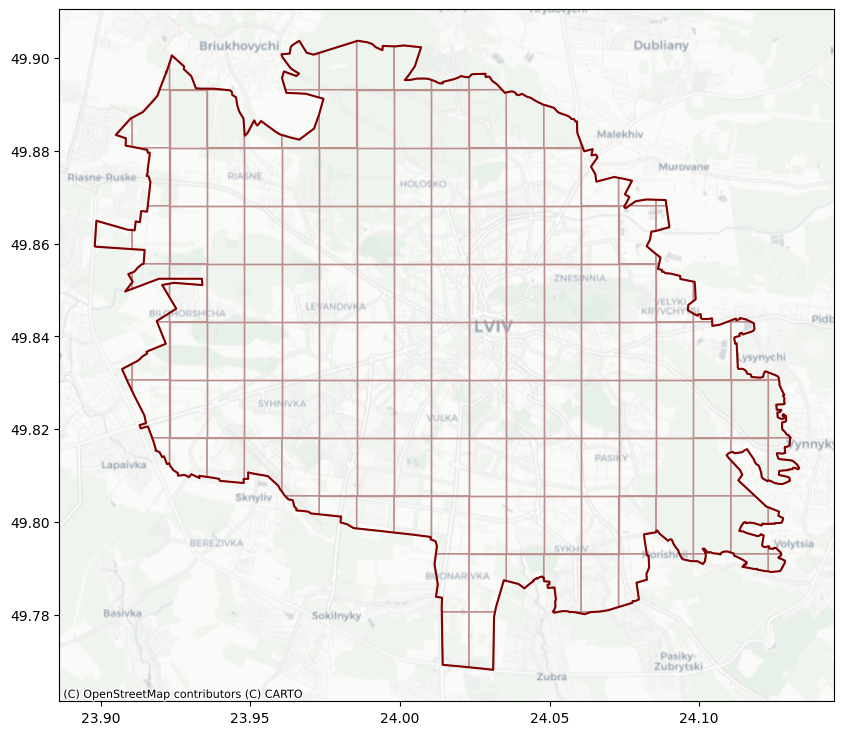

In [174]:
lviv_boundary = ox.geocode_to_gdf("Lviv, Ukraine")

xmin, ymin, xmax, ymax = lviv_boundary.total_bounds
grid_size = 0.0125

grid_cells = []
for x in np.arange(xmin, xmax, grid_size):
    for y in np.arange(ymin, ymax, grid_size):
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=lviv_boundary.crs)
map_with_grid = gpd.clip(grid, lviv_boundary)

ax = map_with_grid.plot(edgecolor="rosybrown", facecolor="none", figsize=(10, 10))
lviv_boundary.boundary.plot(ax=ax, color="maroon")
ctx.add_basemap(ax, crs=lviv_boundary.crs, source=ctx.providers.CartoDB.Positron)

Assigning graph nodes to a grid cell (region)

In [175]:
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_lviv, nodes=True, edges=True)
nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
nodes_in_grid = nodes_in_grid.reset_index()

Handling nodes that are not assigned to any grid cell.\
Creating node to region dictionary and region to nodes dictiionary

In [ ]:
assigned_nodes = nodes_in_grid.dropna(subset=['index_right']) 
missing_nodes = nodes_in_grid[nodes_in_grid['index_right'].isna()]

tree = cKDTree(assigned_nodes[['x', 'y']].values)
_, nearest_idx = tree.query(missing_nodes[['x', 'y']].values)

nodes_in_grid.loc[nodes_in_grid['index_right'].isna(), 'index_right'] = assigned_nodes.iloc[nearest_idx]['index_right'].values
nodes_in_grid['index_right'] = nodes_in_grid['index_right'].astype(int)

# region -> list of nodes
region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)['osmid'].apply(list).to_dict()
# node -> region DI
node_to_region = nodes_in_grid.set_index('osmid')['index_right'].to_dict()
regions = [region for region in region_to_nodes]

C:\Users\tetia\AppData\Local\Temp\ipykernel_47492\1289366606.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


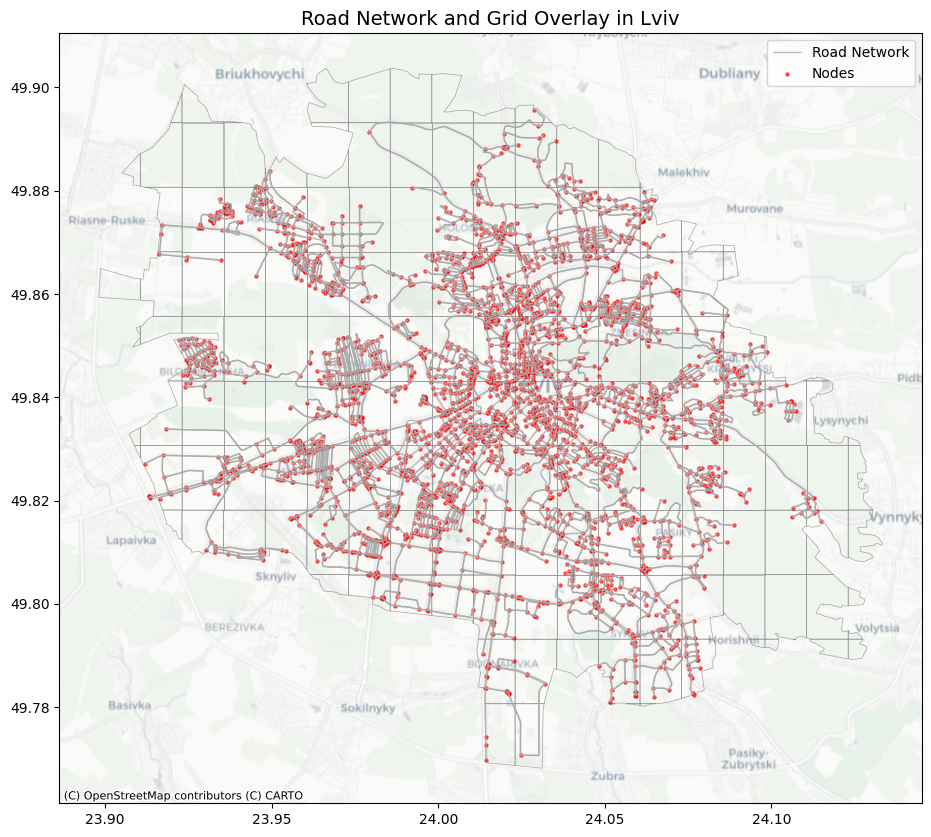

In [178]:
map_with_grid = map_with_grid.to_crs(epsg=4326)
edges_gdf = edges_gdf.to_crs(map_with_grid.crs)
fig, ax = plt.subplots(figsize=(12, 10))

map_with_grid.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.7, label="Grid")

edges_gdf.plot(ax=ax, color="darkgray", linewidth=1, alpha=0.8, label="Road Network")
nodes_gdf.plot(ax=ax, color="red", markersize=5, alpha=0.6, label="Nodes")

ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

ax.set_title("Road Network and Grid Overlay in Lviv", fontsize=14)
ax.legend()
plt.show()


## Demand estimation for each region

### Population count for each sector

In [179]:
raster_file_population = "ukr_ppp_2020_constrained.tif"
with rasterio.open(raster_file_population) as data:
    affine = data.transform
    array = data.read(1)

stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]
map_with_grid["density"] = map_with_grid["population"] / map_with_grid.geometry.area

C:\Users\tetia\AppData\Local\Temp\ipykernel_47492\3548758313.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_with_grid["density"] = map_with_grid["population"] / map_with_grid.geometry.area


In [154]:
# ax = map_with_grid.plot(column="population", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
# lviv_boundary.boundary.plot(ax=ax, color="maroon")
# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)


### Calculation of the number of EV for each sector

In [180]:
EV_ukr = 135200
population_ukr = 31000000
EV_per_capita_ukr = EV_ukr/population_ukr
print("Number of EV per capita:", round(EV_per_capita_ukr, 5))

Number of EV per capita: 0.00436


In [181]:
map_with_grid["EV"] = map_with_grid["population"]*EV_per_capita_ukr
# ax = map_with_grid.plot(column="EV", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
# lviv_boundary.boundary.plot(ax=ax, color="maroon")
# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

### Calculation of charging capacity demand in each region

In [182]:
avg_consumption_per_km = 159.9 #Wh/km
avg_distance_per_day = 33 #km
energy_loss = 0.01 #10%
station_utilization_rate = 0.15 #15%

map_with_grid["daily_energy_consumption"] = avg_consumption_per_km * avg_distance_per_day * map_with_grid["EV"]
map_with_grid["charging_capacity_demand"] = map_with_grid["daily_energy_consumption"]/((1-energy_loss)*station_utilization_rate)

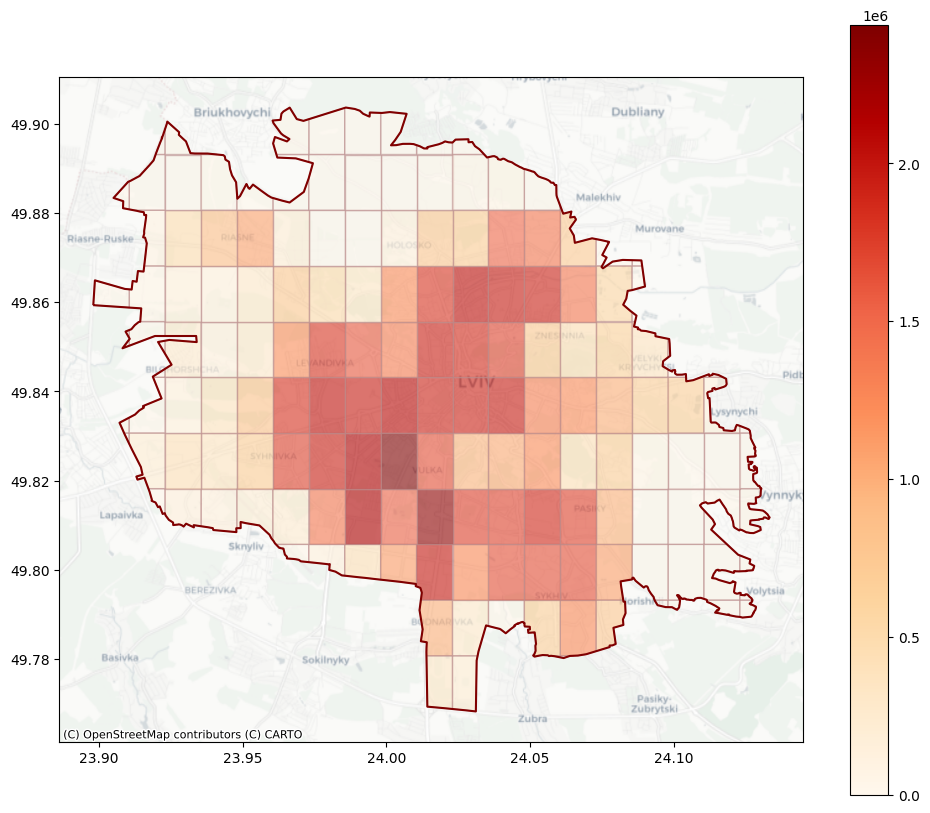

In [183]:
ax = map_with_grid.plot(column="charging_capacity_demand", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
lviv_boundary.boundary.plot(ax=ax, color="maroon")
ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

Creating region to capacity demand dictionary

In [ ]:
map_with_grid = map_with_grid.reset_index()
region_to_capacity_demand = dict()
for grid_cell in range(len(map_with_grid)):
    region_id = map_with_grid.iloc[grid_cell]['index']
    charging_demand = map_with_grid.iloc[grid_cell]['charging_capacity_demand']
    region_to_capacity_demand[region_id] = charging_demand
# region_to_capacity_demand[57]


30277.34349966398

## ojcm

Number of regions

In [ ]:
R = len(regions)    # R

Regions

In [ ]:
region_to_nodes   # r_i

Regions capacity demand

In [ ]:
region_to_capacity_demand    # q_i

# Decision Variables

$X_{2,i}$ - number of level 2 stations in $i$ node\
$X_{3,i}$ - number of level 3 stations in $i$ node

$X_{2/3,i}$ - Non-Negative Integer

In [203]:
# nodes = D_Lviv.nodes
x = {
    (i, "level_2"): LpVariable(f"x_{i}_level_2", cat = "Integer")\
        for i in range(N)
}
x.update({
    (i, "level_3"): LpVariable(f"x_{i}_level_3", cat = "Integer")\
        for i in range(N)
})

# Optimization Problem (1.0)

$min \sum_{i=1}^{N}(C_2*X_{2,i} + C_3*X_{3,i})$

In [204]:
prob = LpProblem("EV_Charging_Stations", LpMinimize)
prob += (
    lpSum(level_2_cost*x[i, 'level_2'] + level_3_cost*x[i, 'level_3'] for i in range(N)),\
        "Total cost"
)

# Optimization Problem (2.0)

$min \sum_{i=1}^{N}(C_2*X_{2,i} + C_3*X_{3,i})$

In [ ]:
# prob = LpProblem("EV_Charging_Stations", LpMinimize)
# prob += (
#     lpSum(level_2_cost*x[i, 'level_2'] + level_3_cost*x[i, 'level_3'] for i in range(N)),\
#         "Total cost"
# )

# Constraints

## Coverage

$\sum_{j = 1, D_{i,j} \le 3000}^{N} (X_{2,j}+X_{3,j}), \forall i \in [1,N]$

In [205]:
max_distance = 3000
for i in range(N):
    prob+= (lpSum(x[j, "level_2"] + x[j, "level_3"]
            for j in range(N)
                if D_Lviv[i, j] <=max_distance),
                    f"Coverage_for_{i}_node")

## Capacity

$\sum_{j\in r_i}(Q_2*X_{2,j} + Q_3*X_{3, j}) \ge q_i, \forall i \in [1, R]$ 

In [206]:
for i in regions:
    prob += (
        lpSum(
            level_2_capacity * x[nodes_dict[node], "level_2"] + level_3_capacity * x[nodes_dict[node], "level_3"]\
            for node in region_to_nodes[i]\
        ) >= region_to_capacity_demand[i],\
        f"Total_capacity_for_region_{i}"
    )

## Number of stations

$X_{2,i} + X_{3,i} \le 4, \forall i \in [1, N]$

In [207]:
for i in range(N):
    prob+=(
        x[i, "level_2"] + x[i, "level_3"] <=4, f"Max_stations_for_node_{i}"
    )

## Non-negativity

$X_{2,i}, X_{3,i} \ge 0$ \
$X_{2,i}, X_{3,i} \in Z, \forall i \in [1, N]$

In [208]:
for i in range(N):
    prob += (x[i, "level_2"] >= 0, f"Non-negativity_for_{i}_node_2")
    prob += (x[i, "level_3"] >= 0, f"Non-negativity_for_{i}_node_3")

# Problem solving

In [209]:
prob.solve()

-1

In [210]:
stations_level_2 = [nodes[i] for i in range(N) if x[i, "level_2"].varValue >= 1]
stations_level_3 = [nodes[i] for i in range(N) if x[i, "level_3"].varValue >= 1]

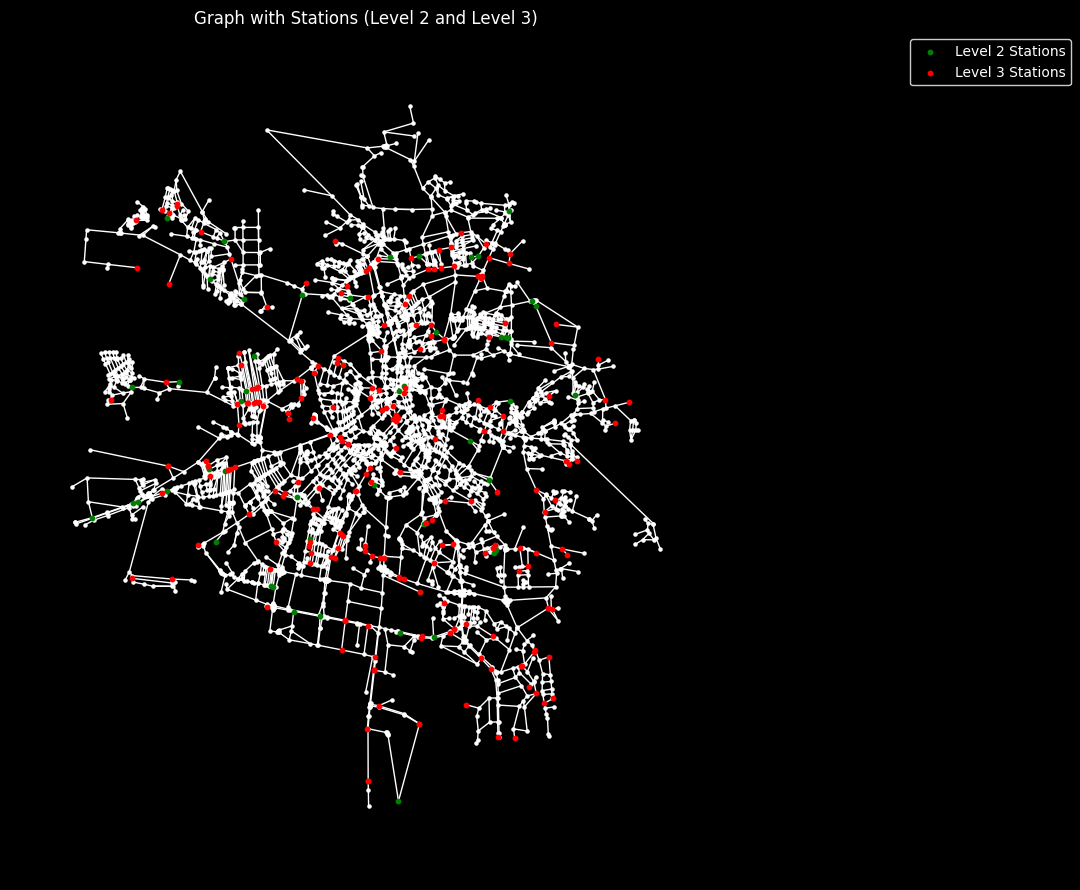

In [211]:
pos = {node: (data['x'], data['y']) for node, data in G_lviv.nodes(data=True)}
G_lviv_undirected = G_lviv.to_undirected()
G_lviv_undirected.remove_edges_from(nx.selfloop_edges(G_lviv_undirected))
fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

nx.draw(G_lviv_undirected, pos, node_size=5, with_labels=False, node_color="white", edge_color="white", ax=ax)

# #Initial level 2 stations
# nx.draw_networkx_nodes(
#     G_lviv_undirected, pos, nodelist=initial_level_2_stations, node_size=30, node_color="lightgreen", label="Initial Level 2 Stations", ax=ax
# )

# #Initial level 3 stations
# nx.draw_networkx_nodes(
#     G_lviv_undirected, pos, nodelist=initial_level_3_stations, node_size=30, node_color="pink", label="Initial Level 3 Stations", ax=ax
# )

#Level 2 stations
nx.draw_networkx_nodes(
    G_lviv_undirected, pos, nodelist=stations_level_2, node_size=10, node_color="green", label="Level 2 Stations", ax=ax
)

#Level 3 stations
nx.draw_networkx_nodes(
    G_lviv_undirected, pos, nodelist=stations_level_3, node_size=10, node_color="red", label="Level 3 Stations", ax=ax
)

legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
for text in legend.get_texts():
    text.set_color("white")

plt.title("Graph with Stations (Level 2 and Level 3)", color="white")
ax.axis("off")

fig.patch.set_facecolor("black")
ax.set_facecolor("black")

plt.tight_layout()
plt.show()